In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from mude_tools import neuralnetplotter
from sklearn.neural_network import MLPRegressor
# use "%matplotlib widget" if on jupyter-lab, or "%matplotlib nbagg" if on jupyter-notebook
%matplotlib nbagg
# %matplotlib widget

## Introduction

Recall that in the previous notebooks we have applied linear models with basis functions
$$ y(x,\mathbf{w}) = \sum_{j=0}^M w_j \phi_j(x) = \mathbf{w}^T \boldsymbol{\phi} (x).$$

Here $\mathbf{w}$ are the flexible parameters, and $\boldsymbol{\phi}$ the basis functions. <!--- One type of basis functions, namely radial basis functions are described by -->

<!--- $$ \phi_j(x) = \exp\left\{-\frac{(x-\mu_j)^2}{2\ell^2}\right\} \quad \mathrm{for} \quad j=1,\dots,M. $$ -->

Because a linear model is linear with respect to its parameters $\mathbf{w}$, we could solve for $\bar{\mathbf{w}}$ directly

$$ \bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.$$

When the data to be described is complex, relying on pre-defined basis functions might not give sufficient accuracy. To overcome this, a more flexible model is required. This can be achieved by replacing the basis functions with parametric functions, in this notebook we will dive into one of these, namely neural networks. The underlying problem will stay the same, where we are trying to learn the underlying relation of a (noisy) process
$$ t = f( x ) $$
based on a limited number of observations $\mathcal{D}=\{\mathbf{x}, \mathbf{t}\}$ from that process. Similarly we are trying to minimize the mean squared error loss function
$$L =  \frac{1}{2N} \sum_{n=1}^N \big(t_n - y(x_n, \mathbf{w}) \big)^2 $$
where $y(x, \mathbf{w})$ now represents a neural network.

<IPython.core.display.Javascript object>


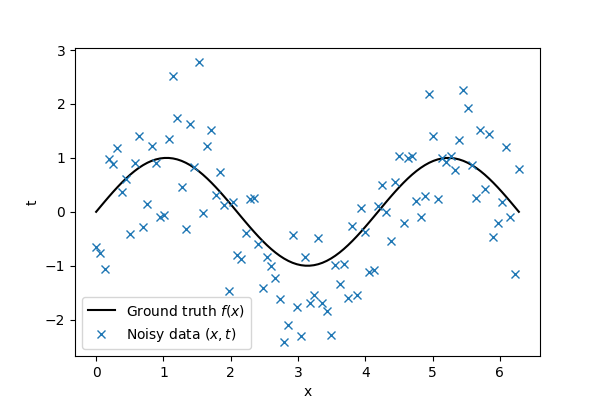

In [2]:
# The true function relating t to x
def f_truth(x, freq=2, **kwargs):

    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)

    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)

    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)

    # Return both the locations and the observations
    return x, t

# Get the observed data
x, t = f_data(freq=1.5)
# x, t = f_data()

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x, f_truth(x, freq=1.5), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

## Neural network architecture
A neural networks consists of neurons connected by weights, with information flowing from input nodes, through 'hidden' nodes, to output nodes. During training, the states of the input and output nodes are known, those of the hidden nodes are not, hence their name.
The state of a neuron is determined by a linear combination of states $z$ from the previous layer with their connecting weights $w$
$$ a^{(l)}_{j} = \sum_{i}^{D} w_{ji}^{(l)} z_{i}^{(l-1)} + w_{j0}^{(l)}  $$
followed by a nonlinear transformation with an activation function:
$$ z^{(l)}_{j} = h(a^{(l)}_{j}).  $$

Plotted here are the identity (or linear), sigmoid, hyperbolic tangent (tanh), and rectified linear unit (relu) activation functions.

<IPython.core.display.Javascript object>


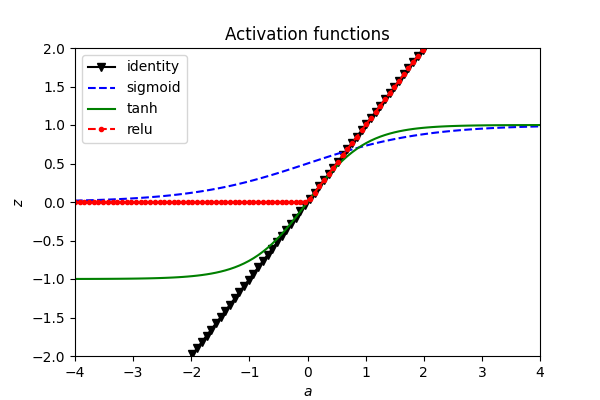

In [3]:
x = np.linspace(-4, 4, 100)

# Compute activation functions
identity = x
sigmoid = [1/(1+np.exp(-x)) for x in x]
tanh = np.tanh(x)
relu = [max(0, x) for x in x]

# Plot figure
plt.figure(figsize=(6,4))
plt.plot(x, identity, 'k-v',label='identity')
plt.plot(x, sigmoid, 'b--',label='sigmoid')
plt.plot(x, tanh, 'g-',label='tanh')
plt.plot(x, relu, 'r.--',label='relu')
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.xlabel('$a$')
plt.ylabel('$z$')
plt.title('Activation functions')
plt.legend()
plt.show()


The number of layers in a neural network commonly refers to the number of hidden layers. The formulation of a two layer neural network is thus:


$$ y(x, \mathbf{w}) = h^{(out)} \left( \sum_{p=0}^{Q} w_{pk}^{(3)} h^{(2)} \big( \sum_{j=0}^{M} w_{kj}^{(2)} h^{(1)} ( \sum_{i=0}^{D} w_{ji}^{(1)} x_i ) \big) \right) $$
With the nonlinear activation functions, this is clearly no longer linear with respect to the weights, and in general no closed form solution can be found. Instead, a form of gradient descent as discussed in the previous notebook is required to minimize a loss function by changing the weights. To do this efficiently, the activation functions are often chosen such that their derivatives are easy to compute. The weights are initialized with random values.
When using a nonlinear activation on the output node, you should be careful that it does not restrict your output space.

When your dataset contains multiple inputs or outputs, this model can easily be extended by including multiple nodes in the input or output layer, the solving procedure stays the same.

The flexibility of a neural network can be adapted by varying the number of nodes in a hidden layer, or by adding several hidden layers. Both of these increase the number of parameters $\mathbf{w}$. When a network has few parameters, it generally leads to an underfit result, whereas having too many parameters quickly leads to overfitting. Finding the right number of layers and nodes per layer are hyperparameters that are found by trial and error.

A different way to prevent overfitting is to regularize the network, similar to applying ridge regression as you've seen in the previous notebook. This can be done by 'punishing' the network for obtaining high weights, called 'weight decay'
$$\tilde{L} = L + \alpha \mathbf{w}^T \mathbf{w}.$$

## Manual model selection
Instead of using a regularization technique, we will try to select the best model ourselves based on how it is trained using gradient descent. By plotting the training loss as well as the validation loss, we can manually select how well the model performs. After training, we can use the slider on the right to go back to different states during training.


<IPython.core.display.Javascript object>


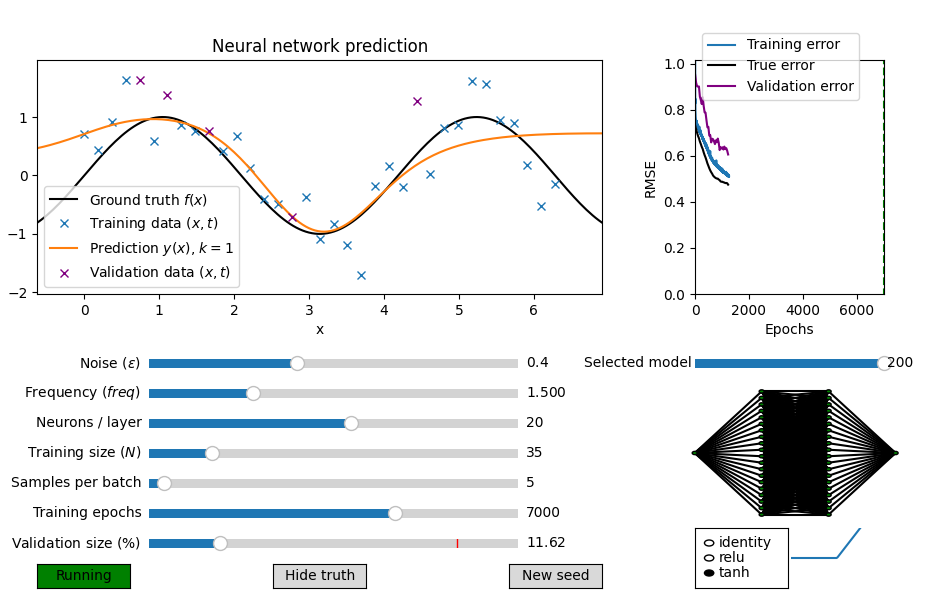

In [4]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(-1, 2*np.pi+1, 200)

# Function that creates a NN
def create_NN(**kwargs):
    return MLPRegressor(solver='sgd', hidden_layer_sizes=(kwargs['neurons'],kwargs['neurons']), activation=kwargs['activation'], batch_size = kwargs['batch_size'])

# Function that trains a given NN for a given number of epochs
def NN_train(neural_network, x, t, **kwargs):
    x = x.reshape(-1, 1)    # Reshape inputs, as it expects a Matrix

    # Run a number of epochs
    for i in range(kwargs['epochs_per_batch']):
        neural_network.partial_fit(x, t)

    return neural_network, neural_network.loss_curve_

# Function that returns predictions from a given NN model
def NN_pred(network, x_pred):
    return network.predict(x_pred.reshape(-1,1))

plot1 = neuralnetplotter(f_data, f_truth, create_NN, NN_train, NN_pred, x_pred, title=r'Neural network prediction')
plot1.add_sliders('epsilon', 'freq', 'neurons', 'N', 'batch_size', 'cur_model', 'epochs', 'val_pct')

# plot1.add_sliders('epsilon', valinit=0.4)
# plot1.add_sliders('freq', valinit=1.5, valmax=5)
# plot1.add_sliders('neurons', valinit=20, valmin=1, valmax=35)
# plot1.add_sliders('N', valinit=35, valmin=1, valmax=200)
# plot1.add_sliders('batch_size', valinit=5)
# plot1.add_sliders('cur_model')
# plot1.add_sliders('epochs', valmin=1000, valinit=7000) #, position='Right')
# plot1.add_sliders('val_pct', valinit=50, valmax=60)

# plot1.add_sidebar()
plot1.add_buttons('truth', 'seed', 'rerun')
plot1.add_radiobuttons('activation', active=2)  #'tanh')  #, 'solver')  # adam vs sgd not informative for this notebook

plot1.show()


As the underlying model is known here, the best model would have a true error equal to the noise. The validation error aims to approximate this true error, and in practice should be used to find the best model.
With the default values, the model is likely to be overfit.
* How can you recognize overfitting based on the training and validation loss curves?
* What is the influence of the number of neurons on overfitting and underfitting?
* Does the model with the lowest validation error always
* In practical situations when dealing with multiple in and outputs, it is often impossible to make the plot on the left. Can you recognize when a model is underfit based only on the loss plot?


For a 2D demonstration, check out the tensorflow playground with 2 dimensional data:  https://playground.tensorflow.org/